In [1]:
from argparse import Namespace

import matplotlib.cm as cm
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

import train_model
from Datasets import Array_Data_DataSet

In [2]:
config = Namespace(
    alpha=0.855530283836263,
    lr=0.000646193982679427,
    feature='CPSD_Phase_Feature',
    label_type='direction',
    curriculum=(-1, -1, -1, -1),
    step_size=10,
    gamma=0.5,
    batch_size=2,
)
val_path = train_model.dataset_path + '/10/val'
r_range = train_model.r_range

In [3]:
checkpoint = torch.load(f'models/{config.feature}_model.pt')
net = train_model.build_model(config)
net.load_state_dict(checkpoint)
net.eval()
net.cuda();

## 在验证集上测试

In [4]:
ds_val = Array_Data_DataSet(val_path, True, config.label_type, r_range)
dl_val = DataLoader(ds_val, batch_size=1, shuffle=True, num_workers=16, drop_last=False)

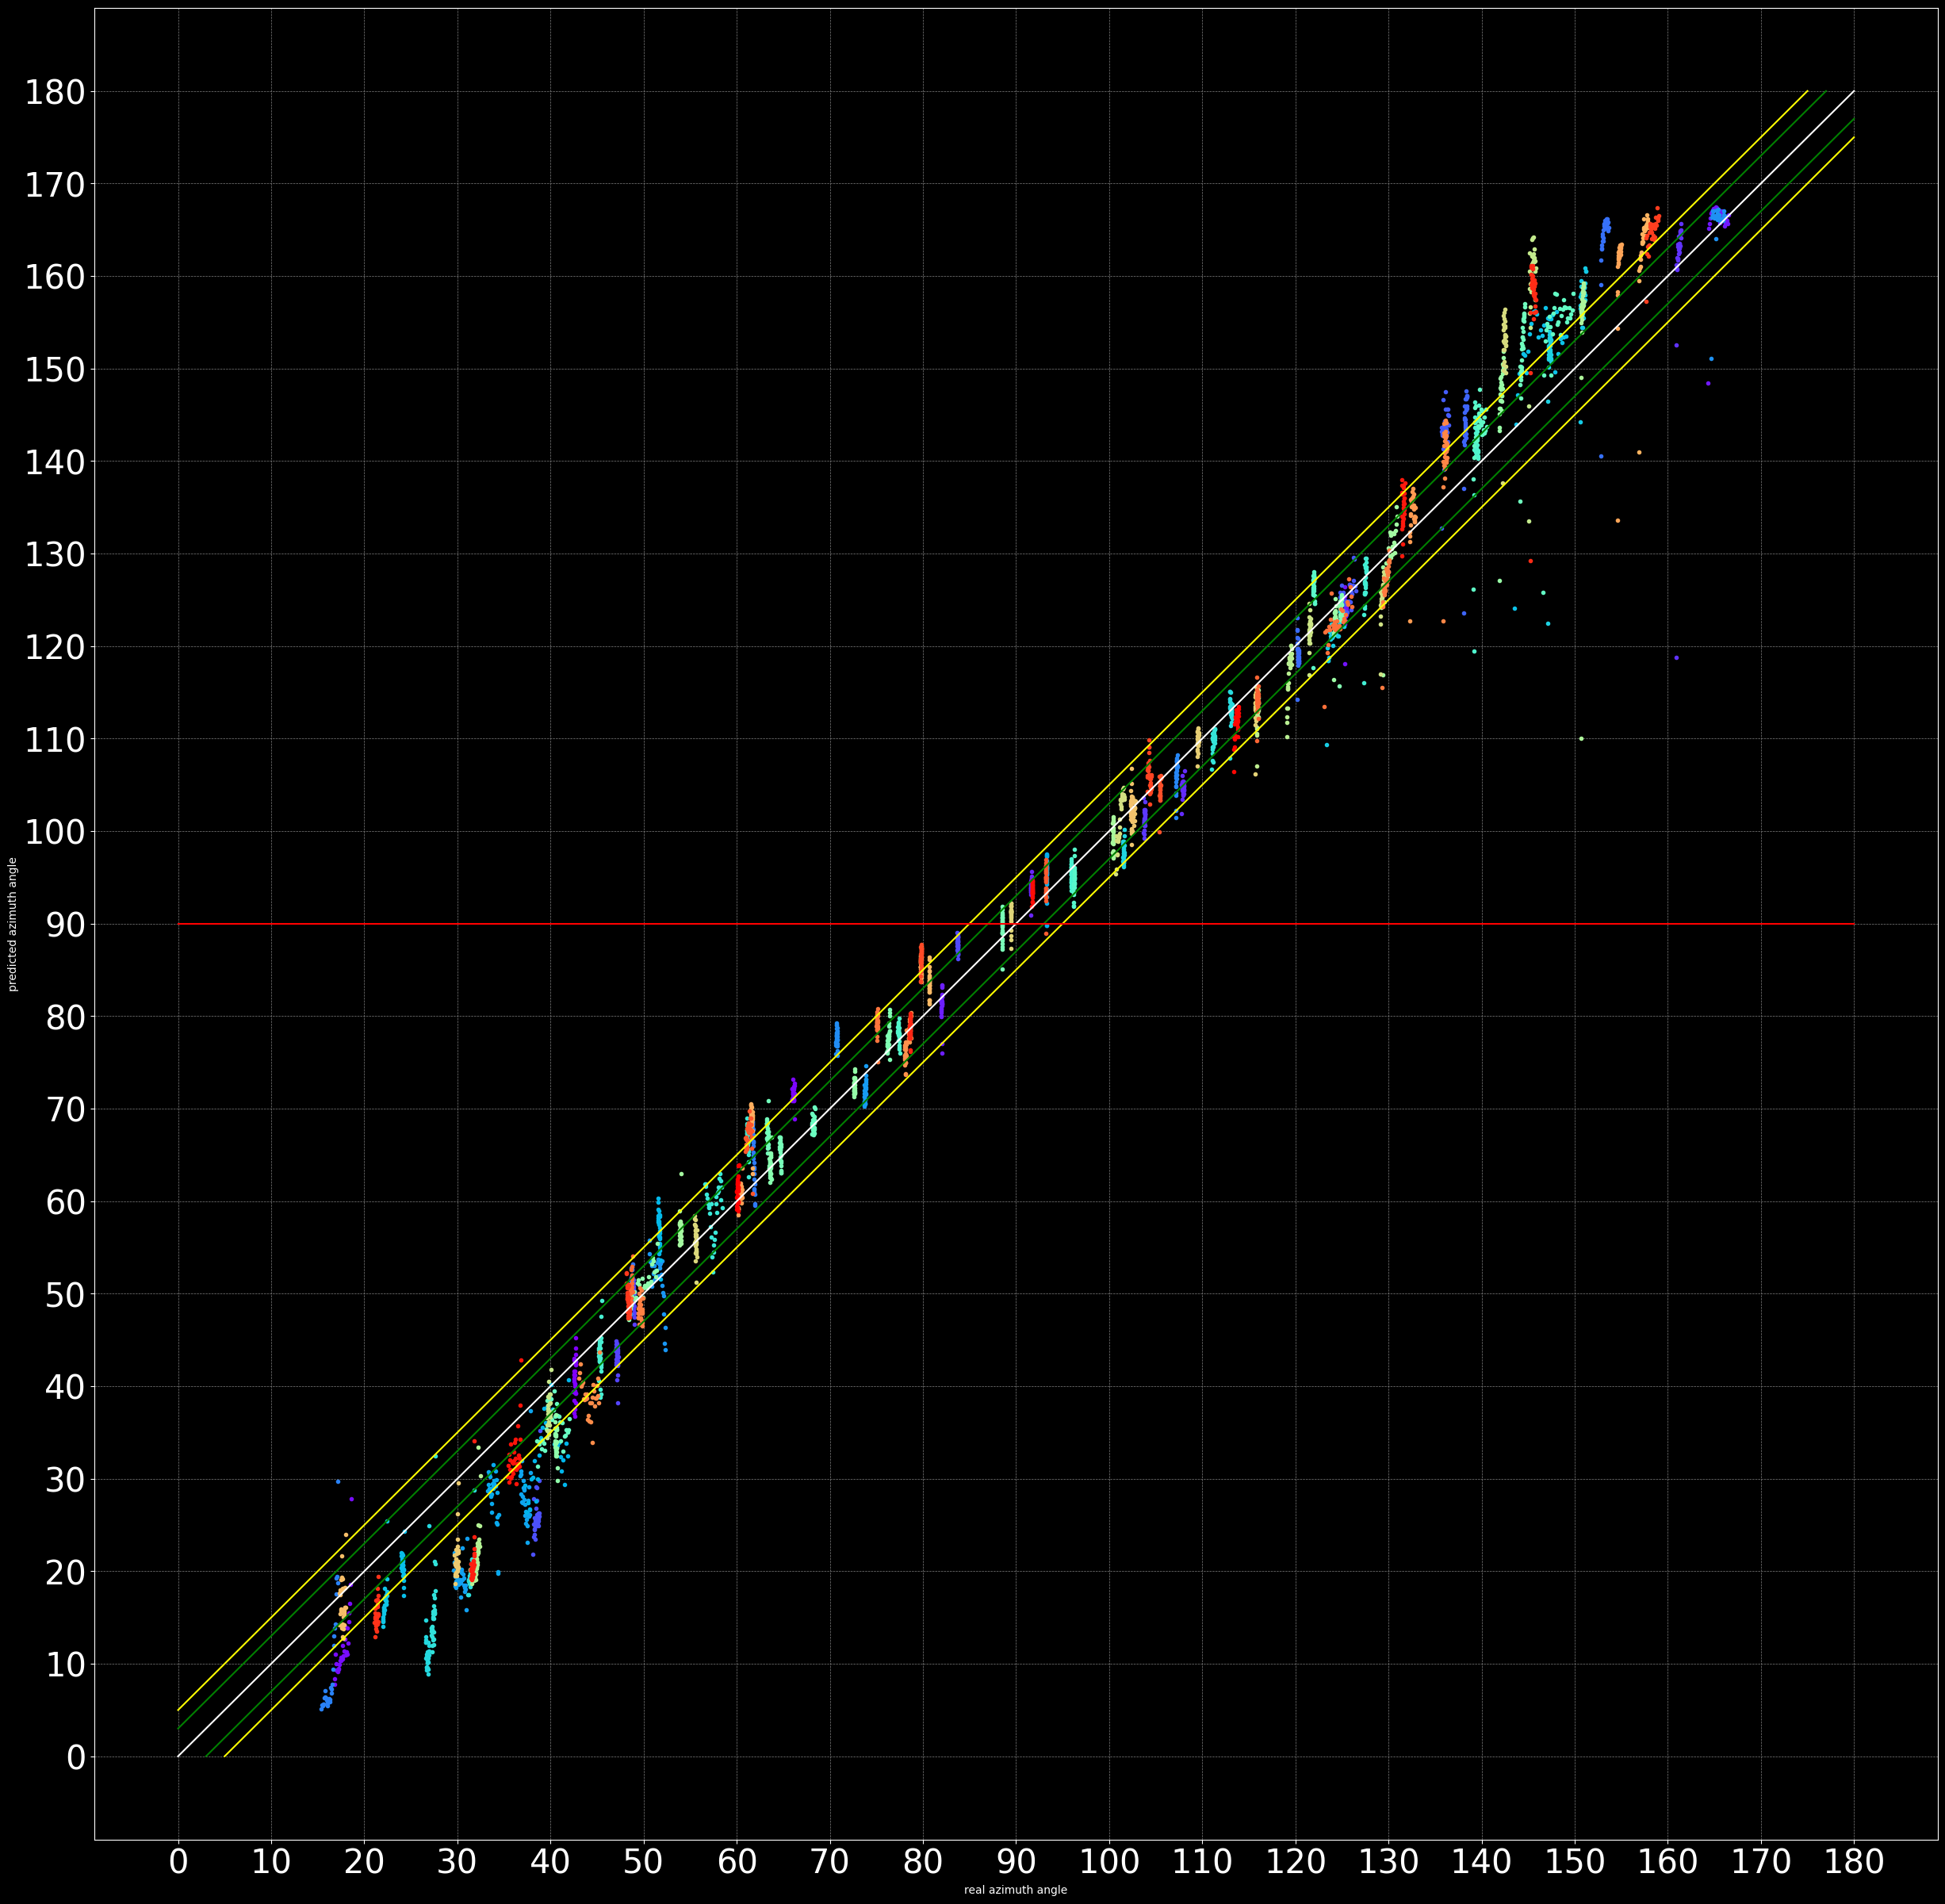

In [7]:
colors = cm.rainbow(np.linspace(0, 1, len(ds_val)))  # type: ignore

plt.figure(figsize=(30, 30))
plt.tick_params(axis='both', which='major', labelsize=30)
for i, (data, labels) in enumerate(dl_val):
    predicted = net(data.cuda())[0].detach().cpu()
    label_angles = ds_val.labels2angles(labels)
    predicted_angles = ds_val.labels2angles(predicted)
    plt.plot(label_angles, predicted_angles, '.', color=colors[i])
plt.plot([0, 180], [0, 180], 'white')
plt.plot([0, 177], [3, 180], 'green')
plt.plot([3, 180], [0, 177], 'green')
plt.plot([0, 175], [5, 180], 'yellow')
plt.plot([5, 180], [0, 175], 'yellow')
plt.plot([0, 180], [90, 90], 'red')

plt.xlabel('real azimuth angle', fontsize=30)
plt.ylabel('predicted azimuth angle', fontsize=30)
plt.xticks(np.arange(0, 190, 10))
plt.yticks(np.arange(0, 190, 10))
plt.grid(True, which='major', color='gray', linestyle='--', linewidth=0.5)

## 实时生成数据测试

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal

import feature_modules
from algorithm import *
from entity import Array_Data_Sampler, CW_Func_Handler, CW_Source, Three_Elements_Array
from utils import *

c = 1500
fc = 42500  # 声源频率
sample_interval = 1  # 采样时长
fs = 8 * fc  # 倍频采样频率
# fs = 500000  # 500k采样率

d = 0.5
K = 1

vel_angle = 90
speed = 0.5
r = 2000
angle = 60

velocity = deg_pol2cart(speed, vel_angle)

target_sig = CW_Func_Handler(
    f=fc,  # 声源频率
    prf=1,  # Cw信号周期
    pulse_width=10e-3,  # Cw信号脉宽
    device='cuda',
)
array_data_sampler = Array_Data_Sampler(
    CW_Source(
    signal_func_callback=target_sig,
    r=r,  # 声源距离
    angle=angle,  # 声源角度
    # seed=1,
    device='cuda',
),
    Three_Elements_Array(
        d=d,
        K=K,
        # seed=1000
        device='cuda',
    ),
    c=c,  # 声速
    device='cuda',
)

# array_data_sampler.set_ideal()
# array_data_sampler.set_SNR(30)
# array_data_sampler.set_SNR(20)
# array_data_sampler.set_SNR(10)
array_data_sampler.set_SNR(5)
# array_data_sampler.set_SNR(-5)
# array_data_sampler.set_SNR(-10)
# array_data_sampler.set_SNR(-15)
# array_data_sampler.set_SNR(-20)

In [ ]:
N = 200
colors = cm.rainbow(np.linspace(0, 1, N))  # type: ignore

plt.figure(figsize=(30, 30))
plt.tick_params(axis='both', which='major', labelsize=30)
t = np.arange(0, sample_interval, 1 / fs)
for i in range(N):
    x, r_real, angle_real, t_bound = array_data_sampler(t, velocity)
    t = t + 10
    data = torch.tensor(x, dtype=torch.float).unsqueeze(0).unsqueeze(0)
    predicted = net(data.cuda())[0].detach().cpu()
    predicted_angles = ds_val.labels2angles(predicted)
    plt.plot(angle_real, float(predicted_angles), '.', color=colors[i])
plt.plot([0, 180], [0, 180], 'white')
plt.plot([0, 177], [3, 180], 'green')
plt.plot([3, 180], [0, 177], 'green')
plt.plot([0, 175], [5, 180], 'yellow')
plt.plot([5, 180], [0, 175], 'yellow')
plt.plot([0, 180], [90, 90], 'red')
plt.xticks(np.arange(0, 190, 10))
plt.yticks(np.arange(0, 190, 10))
plt.grid(True, which='major', color='gray', linestyle='--', linewidth=0.5)
plt.show()